In [25]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pickle
import torch
import pandas as pd
import math
from torch import nn
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt

import torchaudio
from time import time
from IPython.display import Audio, display, clear_output

from torch.utils.data import Dataset, DataLoader
import os.path as osp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
mp3_path = "C:/Users/yagne/Downloads/mp3_tensors.pkl"

In [27]:
data = pd.read_csv("../outputs/summary_data.csv")
data = data[["file", "line", "gs_score"]]
data["line"] = data["line"].astype(str)
data.sample(n=4)

,file,line,gs_score
8772,16-299,126,0.850190
12084,17-961,38,-1.788815
16139,19-930,163,-0.425067
7409,15-680,151,-0.665434


In [28]:
mp3_clips = pickle.load(open(mp3_path, "rb"))
# mp3_clips_select = mp3_clips[:256]
# del(mp3_clips)
mp3_clips = [(c["file"], c["line"]) for c in mp3_clips]

In [5]:
bundle = torchaudio.pipelines.HUBERT_BASE
model = bundle.get_model()
model.eval()
print("")

In [7]:
st = time()
start_point = (
    255  # when the process restarts, starting point, by default `0` will collect all
)
for k, c in enumerate(mp3_clips):
    if k >= start_point:
        clip = c["clip"]
        clip = clip.mean(dim=0).unsqueeze(0)
        features, _ = model.extract_features(c["clip"], num_layers=12)
        clear_output(wait=True)
        print("Item:", k, " |  Progress:", f"{round(100*(k/len(mp3_clips)))}%")
        print(f"Elapsed Time: {round(time() - st, 2)}s")
        print(c["file"], c["line"])
        torch.save(features[-1], f"../outputs/hubert/{c['file']}_{c['line']}.pt")
        del features

Item: 3309  |  Progress: 100%
Elapsed Time: 10779.32s
12-696 257


## MODELING

In [29]:
BATCH_SIZE = 32
EPOCH = 10

In [30]:
class NewHubertDataset(Dataset):
    def __init__(self, clips, metadata, data_dir):
        self.clips = clips
        self.metadata = metadata
        self.data_dir = data_dir

    def __len__(self):
        return len(self.clips)

    def __getitem__(self, idx):
        clip_info = self.clips[idx]
        file, line = clip_info
        file = str(file)
        line = str(line)
        try:
            score = self.metadata.loc[
                (self.metadata["file"] == file) & (self.metadata["line"] == line),
                "gs_score",
            ].values[0]
            score = torch.tensor(score).float()
            score = score.unsqueeze(0)
            data = torch.load(osp.join(self.data_dir, f"{file}_{line}.pt")).float()
            if data.size(0) == 2:
                data = data.mean(dim=0)
            else:
                data = data.squeeze(0)
        except Exception as e:
            print(file, line)
            print(e)
        return data, score

In [31]:
class HUBERTRegressor(nn.Module):
    def __init__(self, hidden_size=768, projection_size=256, debug=False):
        super(HUBERTRegressor, self).__init__()
        self.projector = nn.Linear(hidden_size, projection_size)
        self.regressor = nn.Linear(projection_size, 1)
        self.debug = debug

    def forward(self, x):
        if self.debug:
            print(x.size())
        projected = self.projector(x)
        if self.debug:
            print(projected.size())
        pooled = projected.mean(dim=1)
        if self.debug:
            print(pooled.size())
        pred = self.regressor(pooled)
        if self.debug:
            print(pred.size())
        return pred

In [32]:
# filter loop
mp3_clips_new = []
for m in mp3_clips:
    if m[0] != "141-orig":
        mp3_clips_new.append(m)

In [33]:
train_clips, test_clips = train_test_split(
    mp3_clips_new, test_size=0.1, random_state=42
)

train_data = NewHubertDataset(train_clips, data, "../outputs/hubert/")
test_data = NewHubertDataset(test_clips, data, "../outputs/hubert/")

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

x, y = next(iter(train_dataloader))
print(x.size())
print(y.size())

x, y = next(iter(test_dataloader))
print(x.size())
print(y.size())

torch.Size([32, 999, 768])
torch.Size([32, 1])
torch.Size([32, 999, 768])
torch.Size([32, 1])


In [34]:
m = HUBERTRegressor(debug=True)
_ = m(x)

torch.Size([32, 999, 768])
torch.Size([32, 999, 256])
torch.Size([32, 256])
torch.Size([32, 1])


In [35]:
m = HUBERTRegressor(debug=False)
print(m)

HUBERTRegressor(
  (projector): Linear(in_features=768, out_features=256, bias=True)
  (regressor): Linear(in_features=256, out_features=1, bias=True)
)


In [36]:
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

In [37]:
def train_loop(dataloader, model, loss_fn, optimizer, log):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 8 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            log.append(loss)


def test_loop(dataloader, model, loss_fn, log):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    print(f"Test Error:, Avg loss: {test_loss:>8f} \n")
    log.append(test_loss)

In [38]:
epochs = 100
train_log = []
test_log = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_log.append(train_loop(train_dataloader, m, loss_func, optimizer, train_log))
    test_log.append(test_loop(test_dataloader, m, loss_func, test_log))
    print(train_log)
#     clear_output(wait=True)
#     plt.plot(train_losses,label="train_loss")
#     plt.plot(test_losses, label="test_loss")
#     plt.legend()
#     plt.show()
print("Done!")

Epoch 1
-------------------------------
loss: 0.457118  [    0/ 2954]
loss: 0.525076  [  256/ 2954]
loss: 0.590481  [  512/ 2954]
loss: 0.305106  [  768/ 2954]
loss: 0.394985  [ 1024/ 2954]
loss: 0.391280  [ 1280/ 2954]
loss: 0.601478  [ 1536/ 2954]
loss: 0.362525  [ 1792/ 2954]
loss: 0.284946  [ 2048/ 2954]
loss: 0.440489  [ 2304/ 2954]
loss: 0.542651  [ 2560/ 2954]
loss: 0.439893  [ 2816/ 2954]
Test Error:, Avg loss: 0.514212 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None]
Epoch 2
-------------------------------
loss: 0.404849  [    0/ 2954]
loss: 0.582078  [  256/ 2954]
loss: 0.686244  [  512/ 2954]
loss: 0.295723  [  768/ 2954]
loss: 0.422097  [ 1024/ 2954]
loss: 0.390294  [ 1280/ 2954]
loss: 0.562028  [ 1536/ 2954]
loss: 0.350153  [ 1792/ 2954]
loss: 0.292907  [ 2048/ 2954]
loss: 

loss: 0.431188  [ 2816/ 2954]
Test Error:, Avg loss: 0.463175 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.3757359981536865, 0.5587567090988159, 0.346478670835495, 0.3012038469314575, 0.42693960666656494, 0.5069343447685242, 0.43933239579200745, None, 0.40693482756614685, 0.5729516744613647, 0.606774091720581, 0.2735760807991028, 0.4183652997016907, 0.3750651180744171, 0.5578146576881409, 0.34578749537467957, 0.29675808548927307, 0.4284678

loss: 0.404043  [    0/ 2954]
loss: 0.557112  [  256/ 2954]
loss: 0.611804  [  512/ 2954]
loss: 0.276488  [  768/ 2954]
loss: 0.417835  [ 1024/ 2954]
loss: 0.375022  [ 1280/ 2954]
loss: 0.554450  [ 1536/ 2954]
loss: 0.341004  [ 1792/ 2954]
loss: 0.277064  [ 2048/ 2954]
loss: 0.430741  [ 2304/ 2954]
loss: 0.505069  [ 2560/ 2954]
loss: 0.423582  [ 2816/ 2954]
Test Error:, Avg loss: 0.462020 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.401694  [    0/ 2954]
loss: 0.556611  [  256/ 2954]
loss: 0.616357  [  512/ 2954]
loss: 0.278930  [  768/ 2954]
loss: 0.415579  [ 1024/ 2954]
loss: 0.376267  [ 1280/ 2954]
loss: 0.549326  [ 1536/ 2954]
loss: 0.338150  [ 1792/ 2954]
loss: 0.265962  [ 2048/ 2954]
loss: 0.428033  [ 2304/ 2954]
loss: 0.503153  [ 2560/ 2954]
loss: 0.418932  [ 2816/ 2954]
Test Error:, Avg loss: 0.462861 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.414721  [ 1024/ 2954]
loss: 0.376483  [ 1280/ 2954]
loss: 0.548310  [ 1536/ 2954]
loss: 0.336535  [ 1792/ 2954]
loss: 0.261600  [ 2048/ 2954]
loss: 0.426581  [ 2304/ 2954]
loss: 0.503148  [ 2560/ 2954]
loss: 0.417749  [ 2816/ 2954]
Test Error:, Avg loss: 0.462099 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.3757359981536865, 0.5587567090988159, 0.346478670835495, 0.3012038469314575, 0.42693960666656494, 0.5069343447685242, 0.439332

loss: 0.404572  [    0/ 2954]
loss: 0.557150  [  256/ 2954]
loss: 0.619611  [  512/ 2954]
loss: 0.278689  [  768/ 2954]
loss: 0.414344  [ 1024/ 2954]
loss: 0.375094  [ 1280/ 2954]
loss: 0.547814  [ 1536/ 2954]
loss: 0.335092  [ 1792/ 2954]
loss: 0.259373  [ 2048/ 2954]
loss: 0.424516  [ 2304/ 2954]
loss: 0.503915  [ 2560/ 2954]
loss: 0.413622  [ 2816/ 2954]
Test Error:, Avg loss: 0.464055 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.401984  [    0/ 2954]
loss: 0.555502  [  256/ 2954]
loss: 0.622988  [  512/ 2954]
loss: 0.280326  [  768/ 2954]
loss: 0.411370  [ 1024/ 2954]
loss: 0.377792  [ 1280/ 2954]
loss: 0.544273  [ 1536/ 2954]
loss: 0.332188  [ 1792/ 2954]
loss: 0.257258  [ 2048/ 2954]
loss: 0.422938  [ 2304/ 2954]
loss: 0.503549  [ 2560/ 2954]
loss: 0.409126  [ 2816/ 2954]
Test Error:, Avg loss: 0.464978 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.398657  [    0/ 2954]
loss: 0.556229  [  256/ 2954]
loss: 0.625805  [  512/ 2954]
loss: 0.279819  [  768/ 2954]
loss: 0.410803  [ 1024/ 2954]
loss: 0.376969  [ 1280/ 2954]
loss: 0.544159  [ 1536/ 2954]
loss: 0.329515  [ 1792/ 2954]
loss: 0.253277  [ 2048/ 2954]
loss: 0.420481  [ 2304/ 2954]
loss: 0.503007  [ 2560/ 2954]
loss: 0.408249  [ 2816/ 2954]
Test Error:, Avg loss: 0.465935 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.400630  [    0/ 2954]
loss: 0.554863  [  256/ 2954]
loss: 0.622799  [  512/ 2954]
loss: 0.282017  [  768/ 2954]
loss: 0.407702  [ 1024/ 2954]
loss: 0.380817  [ 1280/ 2954]
loss: 0.543142  [ 1536/ 2954]
loss: 0.327896  [ 1792/ 2954]
loss: 0.250301  [ 2048/ 2954]
loss: 0.422822  [ 2304/ 2954]
loss: 0.505212  [ 2560/ 2954]
loss: 0.409558  [ 2816/ 2954]
Test Error:, Avg loss: 0.465989 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.405365  [    0/ 2954]
loss: 0.558903  [  256/ 2954]
loss: 0.620654  [  512/ 2954]
loss: 0.279396  [  768/ 2954]
loss: 0.407210  [ 1024/ 2954]
loss: 0.382499  [ 1280/ 2954]
loss: 0.543278  [ 1536/ 2954]
loss: 0.327378  [ 1792/ 2954]
loss: 0.251474  [ 2048/ 2954]
loss: 0.419858  [ 2304/ 2954]
loss: 0.510582  [ 2560/ 2954]
loss: 0.402572  [ 2816/ 2954]
Test Error:, Avg loss: 0.471577 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.401326  [    0/ 2954]
loss: 0.562449  [  256/ 2954]
loss: 0.630562  [  512/ 2954]
loss: 0.279908  [  768/ 2954]
loss: 0.405324  [ 1024/ 2954]
loss: 0.384864  [ 1280/ 2954]
loss: 0.538356  [ 1536/ 2954]
loss: 0.325985  [ 1792/ 2954]
loss: 0.253417  [ 2048/ 2954]
loss: 0.417727  [ 2304/ 2954]
loss: 0.511096  [ 2560/ 2954]
loss: 0.393499  [ 2816/ 2954]
Test Error:, Avg loss: 0.475960 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.392738  [    0/ 2954]
loss: 0.561900  [  256/ 2954]
loss: 0.634013  [  512/ 2954]
loss: 0.281130  [  768/ 2954]
loss: 0.401336  [ 1024/ 2954]
loss: 0.385779  [ 1280/ 2954]
loss: 0.531865  [ 1536/ 2954]
loss: 0.321325  [ 1792/ 2954]
loss: 0.250557  [ 2048/ 2954]
loss: 0.416104  [ 2304/ 2954]
loss: 0.509144  [ 2560/ 2954]
loss: 0.390281  [ 2816/ 2954]
Test Error:, Avg loss: 0.479920 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.391806  [ 2816/ 2954]
Test Error:, Avg loss: 0.480197 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.3757359981536865, 0.5587567090988159, 0.346478670835495, 0.3012038469314575, 0.42693960666656494, 0.5069343447685242, 0.43933239579200745, None, 0.40693482756614685, 0.5729516744613647, 0.606774091720581, 0.2735760807991028, 0.4183652997016907, 0.3750651180744171, 0.5578146576881409, 0.34578749537467957, 0.29675808548927307, 0.4284678

loss: 0.389431  [    0/ 2954]
loss: 0.557448  [  256/ 2954]
loss: 0.631436  [  512/ 2954]
loss: 0.280750  [  768/ 2954]
loss: 0.403904  [ 1024/ 2954]
loss: 0.385309  [ 1280/ 2954]
loss: 0.534818  [ 1536/ 2954]
loss: 0.317516  [ 1792/ 2954]
loss: 0.246946  [ 2048/ 2954]
loss: 0.417518  [ 2304/ 2954]
loss: 0.505045  [ 2560/ 2954]
loss: 0.398343  [ 2816/ 2954]
Test Error:, Avg loss: 0.473035 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.394937  [    0/ 2954]
loss: 0.557610  [  256/ 2954]
loss: 0.623286  [  512/ 2954]
loss: 0.281194  [  768/ 2954]
loss: 0.403844  [ 1024/ 2954]
loss: 0.385127  [ 1280/ 2954]
loss: 0.537299  [ 1536/ 2954]
loss: 0.318778  [ 1792/ 2954]
loss: 0.245713  [ 2048/ 2954]
loss: 0.420096  [ 2304/ 2954]
loss: 0.507504  [ 2560/ 2954]
loss: 0.398873  [ 2816/ 2954]
Test Error:, Avg loss: 0.473651 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.399295  [    0/ 2954]
loss: 0.558485  [  256/ 2954]
loss: 0.621067  [  512/ 2954]
loss: 0.283294  [  768/ 2954]
loss: 0.402275  [ 1024/ 2954]
loss: 0.386525  [ 1280/ 2954]
loss: 0.537581  [ 1536/ 2954]
loss: 0.319363  [ 1792/ 2954]
loss: 0.244751  [ 2048/ 2954]
loss: 0.420723  [ 2304/ 2954]
loss: 0.510411  [ 2560/ 2954]
loss: 0.397593  [ 2816/ 2954]
Test Error:, Avg loss: 0.475536 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.401191  [    0/ 2954]
loss: 0.559197  [  256/ 2954]
loss: 0.623441  [  512/ 2954]
loss: 0.285690  [  768/ 2954]
loss: 0.400724  [ 1024/ 2954]
loss: 0.387925  [ 1280/ 2954]
loss: 0.536644  [ 1536/ 2954]
loss: 0.319521  [ 1792/ 2954]
loss: 0.244561  [ 2048/ 2954]
loss: 0.420401  [ 2304/ 2954]
loss: 0.513101  [ 2560/ 2954]
loss: 0.395155  [ 2816/ 2954]
Test Error:, Avg loss: 0.477813 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.401731  [    0/ 2954]
loss: 0.559967  [  256/ 2954]
loss: 0.627402  [  512/ 2954]
loss: 0.286795  [  768/ 2954]
loss: 0.400050  [ 1024/ 2954]
loss: 0.388391  [ 1280/ 2954]
loss: 0.535840  [ 1536/ 2954]
loss: 0.319549  [ 1792/ 2954]
loss: 0.245111  [ 2048/ 2954]
loss: 0.418323  [ 2304/ 2954]
loss: 0.514136  [ 2560/ 2954]
loss: 0.392396  [ 2816/ 2954]
Test Error:, Avg loss: 0.479138 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.401554  [    0/ 2954]
loss: 0.560472  [  256/ 2954]
loss: 0.629064  [  512/ 2954]
loss: 0.285636  [  768/ 2954]
loss: 0.400088  [ 1024/ 2954]
loss: 0.388484  [ 1280/ 2954]
loss: 0.534473  [ 1536/ 2954]
loss: 0.319272  [ 1792/ 2954]
loss: 0.246201  [ 2048/ 2954]
loss: 0.415797  [ 2304/ 2954]
loss: 0.514431  [ 2560/ 2954]
loss: 0.388739  [ 2816/ 2954]
Test Error:, Avg loss: 0.480387 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.399774  [    0/ 2954]
loss: 0.561365  [  256/ 2954]
loss: 0.630495  [  512/ 2954]
loss: 0.284113  [  768/ 2954]
loss: 0.399849  [ 1024/ 2954]
loss: 0.389048  [ 1280/ 2954]
loss: 0.532445  [ 1536/ 2954]
loss: 0.318492  [ 1792/ 2954]
loss: 0.247153  [ 2048/ 2954]
loss: 0.413615  [ 2304/ 2954]
loss: 0.513873  [ 2560/ 2954]
loss: 0.385489  [ 2816/ 2954]
Test Error:, Avg loss: 0.481250 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.397319  [    0/ 2954]
loss: 0.562064  [  256/ 2954]
loss: 0.631108  [  512/ 2954]
loss: 0.283036  [  768/ 2954]
loss: 0.399129  [ 1024/ 2954]
loss: 0.389684  [ 1280/ 2954]
loss: 0.529631  [ 1536/ 2954]
loss: 0.317229  [ 1792/ 2954]
loss: 0.247431  [ 2048/ 2954]
loss: 0.412638  [ 2304/ 2954]
loss: 0.512774  [ 2560/ 2954]
loss: 0.382936  [ 2816/ 2954]
Test Error:, Avg loss: 0.482066 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.394588  [    0/ 2954]
loss: 0.562406  [  256/ 2954]
loss: 0.630871  [  512/ 2954]
loss: 0.282395  [  768/ 2954]
loss: 0.398103  [ 1024/ 2954]
loss: 0.390290  [ 1280/ 2954]
loss: 0.526783  [ 1536/ 2954]
loss: 0.315550  [ 1792/ 2954]
loss: 0.247302  [ 2048/ 2954]
loss: 0.411845  [ 2304/ 2954]
loss: 0.511615  [ 2560/ 2954]
loss: 0.381385  [ 2816/ 2954]
Test Error:, Avg loss: 0.483329 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.390693  [    0/ 2954]
loss: 0.562099  [  256/ 2954]
loss: 0.631489  [  512/ 2954]
loss: 0.282894  [  768/ 2954]
loss: 0.396753  [ 1024/ 2954]
loss: 0.391227  [ 1280/ 2954]
loss: 0.524223  [ 1536/ 2954]
loss: 0.313532  [ 1792/ 2954]
loss: 0.247152  [ 2048/ 2954]
loss: 0.411159  [ 2304/ 2954]
loss: 0.510847  [ 2560/ 2954]
loss: 0.381510  [ 2816/ 2954]
Test Error:, Avg loss: 0.484164 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.387956  [    0/ 2954]
loss: 0.560572  [  256/ 2954]
loss: 0.632038  [  512/ 2954]
loss: 0.282930  [  768/ 2954]
loss: 0.396924  [ 1024/ 2954]
loss: 0.391264  [ 1280/ 2954]
loss: 0.523720  [ 1536/ 2954]
loss: 0.311703  [ 1792/ 2954]
loss: 0.247013  [ 2048/ 2954]
loss: 0.411667  [ 2304/ 2954]
loss: 0.510602  [ 2560/ 2954]
loss: 0.382905  [ 2816/ 2954]
Test Error:, Avg loss: 0.483927 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.387396  [    0/ 2954]
loss: 0.559401  [  256/ 2954]
loss: 0.630408  [  512/ 2954]
loss: 0.282093  [  768/ 2954]
loss: 0.398196  [ 1024/ 2954]
loss: 0.390682  [ 1280/ 2954]
loss: 0.525519  [ 1536/ 2954]
loss: 0.310547  [ 1792/ 2954]
loss: 0.246940  [ 2048/ 2954]
loss: 0.412801  [ 2304/ 2954]
loss: 0.511320  [ 2560/ 2954]
loss: 0.384666  [ 2816/ 2954]
Test Error:, Avg loss: 0.483289 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.388139  [    0/ 2954]
loss: 0.558993  [  256/ 2954]
loss: 0.628942  [  512/ 2954]
loss: 0.281587  [  768/ 2954]
loss: 0.399266  [ 1024/ 2954]
loss: 0.390075  [ 1280/ 2954]
loss: 0.527910  [ 1536/ 2954]
loss: 0.310212  [ 1792/ 2954]
loss: 0.246540  [ 2048/ 2954]
loss: 0.415117  [ 2304/ 2954]
loss: 0.512639  [ 2560/ 2954]
loss: 0.385670  [ 2816/ 2954]
Test Error:, Avg loss: 0.482720 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.390244  [    0/ 2954]
loss: 0.559259  [  256/ 2954]
loss: 0.626951  [  512/ 2954]
loss: 0.282067  [  768/ 2954]
loss: 0.399325  [ 1024/ 2954]
loss: 0.390215  [ 1280/ 2954]
loss: 0.529194  [ 1536/ 2954]
loss: 0.310479  [ 1792/ 2954]
loss: 0.245842  [ 2048/ 2954]
loss: 0.417431  [ 2304/ 2954]
loss: 0.515058  [ 2560/ 2954]
loss: 0.385658  [ 2816/ 2954]
Test Error:, Avg loss: 0.482715 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.392152  [    0/ 2954]
loss: 0.559459  [  256/ 2954]
loss: 0.626474  [  512/ 2954]
loss: 0.283490  [  768/ 2954]
loss: 0.398311  [ 1024/ 2954]
loss: 0.391045  [ 1280/ 2954]
loss: 0.528863  [ 1536/ 2954]
loss: 0.310668  [ 1792/ 2954]
loss: 0.245035  [ 2048/ 2954]
loss: 0.419740  [ 2304/ 2954]
loss: 0.517886  [ 2560/ 2954]
loss: 0.384872  [ 2816/ 2954]
Test Error:, Avg loss: 0.483298 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.393636  [    0/ 2954]
loss: 0.559721  [  256/ 2954]
loss: 0.627125  [  512/ 2954]
loss: 0.285302  [  768/ 2954]
loss: 0.397135  [ 1024/ 2954]
loss: 0.392151  [ 1280/ 2954]
loss: 0.527811  [ 1536/ 2954]
loss: 0.310695  [ 1792/ 2954]
loss: 0.244442  [ 2048/ 2954]
loss: 0.421259  [ 2304/ 2954]
loss: 0.521172  [ 2560/ 2954]
loss: 0.383368  [ 2816/ 2954]
Test Error:, Avg loss: 0.484854 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.394069  [    0/ 2954]
loss: 0.559764  [  256/ 2954]
loss: 0.630323  [  512/ 2954]
loss: 0.286848  [  768/ 2954]
loss: 0.396248  [ 1024/ 2954]
loss: 0.392873  [ 1280/ 2954]
loss: 0.526819  [ 1536/ 2954]
loss: 0.310562  [ 1792/ 2954]
loss: 0.244151  [ 2048/ 2954]
loss: 0.421632  [ 2304/ 2954]
loss: 0.524070  [ 2560/ 2954]
loss: 0.381290  [ 2816/ 2954]
Test Error:, Avg loss: 0.486810 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.393485  [    0/ 2954]
loss: 0.559916  [  256/ 2954]
loss: 0.634859  [  512/ 2954]
loss: 0.287568  [  768/ 2954]
loss: 0.396015  [ 1024/ 2954]
loss: 0.392723  [ 1280/ 2954]
loss: 0.525954  [ 1536/ 2954]
loss: 0.310413  [ 1792/ 2954]
loss: 0.244266  [ 2048/ 2954]
loss: 0.420830  [ 2304/ 2954]
loss: 0.525564  [ 2560/ 2954]
loss: 0.378600  [ 2816/ 2954]
Test Error:, Avg loss: 0.488732 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.392476  [    0/ 2954]
loss: 0.560208  [  256/ 2954]
loss: 0.639045  [  512/ 2954]
loss: 0.287203  [  768/ 2954]
loss: 0.395971  [ 1024/ 2954]
loss: 0.392270  [ 1280/ 2954]
loss: 0.524698  [ 1536/ 2954]
loss: 0.310092  [ 1792/ 2954]
loss: 0.244944  [ 2048/ 2954]
loss: 0.418986  [ 2304/ 2954]
loss: 0.525649  [ 2560/ 2954]
loss: 0.375657  [ 2816/ 2954]
Test Error:, Avg loss: 0.490462 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.390316  [    0/ 2954]
loss: 0.560404  [  256/ 2954]
loss: 0.642203  [  512/ 2954]
loss: 0.287301  [  768/ 2954]
loss: 0.394905  [ 1024/ 2954]
loss: 0.392752  [ 1280/ 2954]
loss: 0.522455  [ 1536/ 2954]
loss: 0.309279  [ 1792/ 2954]
loss: 0.245752  [ 2048/ 2954]
loss: 0.417395  [ 2304/ 2954]
loss: 0.524883  [ 2560/ 2954]
loss: 0.373414  [ 2816/ 2954]
Test Error:, Avg loss: 0.491844 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.388392  [    0/ 2954]
loss: 0.560404  [  256/ 2954]
loss: 0.643696  [  512/ 2954]
loss: 0.287173  [  768/ 2954]
loss: 0.393823  [ 1024/ 2954]
loss: 0.393435  [ 1280/ 2954]
loss: 0.520390  [ 1536/ 2954]
loss: 0.308144  [ 1792/ 2954]
loss: 0.246361  [ 2048/ 2954]
loss: 0.416101  [ 2304/ 2954]
loss: 0.523134  [ 2560/ 2954]
loss: 0.372233  [ 2816/ 2954]
Test Error:, Avg loss: 0.492303 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.387331  [    0/ 2954]
loss: 0.560400  [  256/ 2954]
loss: 0.642365  [  512/ 2954]
loss: 0.286290  [  768/ 2954]
loss: 0.393144  [ 1024/ 2954]
loss: 0.394170  [ 1280/ 2954]
loss: 0.518904  [ 1536/ 2954]
loss: 0.306917  [ 1792/ 2954]
loss: 0.246858  [ 2048/ 2954]
loss: 0.416227  [ 2304/ 2954]
loss: 0.522875  [ 2560/ 2954]
loss: 0.371740  [ 2816/ 2954]
Test Error:, Avg loss: 0.493090 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.386078  [    0/ 2954]
loss: 0.560117  [  256/ 2954]
loss: 0.640704  [  512/ 2954]
loss: 0.285743  [  768/ 2954]
loss: 0.392535  [ 1024/ 2954]
loss: 0.394890  [ 1280/ 2954]
loss: 0.518196  [ 1536/ 2954]
loss: 0.305573  [ 1792/ 2954]
loss: 0.247172  [ 2048/ 2954]
loss: 0.417048  [ 2304/ 2954]
loss: 0.524127  [ 2560/ 2954]
loss: 0.371866  [ 2816/ 2954]
Test Error:, Avg loss: 0.494435 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.385028  [    0/ 2954]
loss: 0.559231  [  256/ 2954]
loss: 0.640764  [  512/ 2954]
loss: 0.285858  [  768/ 2954]
loss: 0.392353  [ 1024/ 2954]
loss: 0.395361  [ 1280/ 2954]
loss: 0.518444  [ 1536/ 2954]
loss: 0.304354  [ 1792/ 2954]
loss: 0.247178  [ 2048/ 2954]
loss: 0.418417  [ 2304/ 2954]
loss: 0.525358  [ 2560/ 2954]
loss: 0.372198  [ 2816/ 2954]
Test Error:, Avg loss: 0.495347 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.385252  [    0/ 2954]
loss: 0.558554  [  256/ 2954]
loss: 0.640819  [  512/ 2954]
loss: 0.285661  [  768/ 2954]
loss: 0.392566  [ 1024/ 2954]
loss: 0.395789  [ 1280/ 2954]
loss: 0.519298  [ 1536/ 2954]
loss: 0.303698  [ 1792/ 2954]
loss: 0.247149  [ 2048/ 2954]
loss: 0.420149  [ 2304/ 2954]
loss: 0.526838  [ 2560/ 2954]
loss: 0.372293  [ 2816/ 2954]
Test Error:, Avg loss: 0.495842 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.385520  [    0/ 2954]
loss: 0.558343  [  256/ 2954]
loss: 0.640293  [  512/ 2954]
loss: 0.285420  [  768/ 2954]
loss: 0.392782  [ 1024/ 2954]
loss: 0.396196  [ 1280/ 2954]
loss: 0.519930  [ 1536/ 2954]
loss: 0.303369  [ 1792/ 2954]
loss: 0.247028  [ 2048/ 2954]
loss: 0.422047  [ 2304/ 2954]
loss: 0.528624  [ 2560/ 2954]
loss: 0.371938  [ 2816/ 2954]
Test Error:, Avg loss: 0.496472 

[0.4571176767349243, 0.5250756144523621, 0.5904809236526489, 0.30510637164115906, 0.3949853777885437, 0.3912796080112457, 0.6014784574508667, 0.36252495646476746, 0.28494614362716675, 0.4404892325401306, 0.5426506400108337, 0.4398932456970215, None, 0.404848575592041, 0.5820784568786621, 0.6862439513206482, 0.29572272300720215, 0.4220971465110779, 0.39029401540756226, 0.5620281100273132, 0.3501529395580292, 0.2929072976112366, 0.4351556897163391, 0.5094286203384399, 0.4402276277542114, None, 0.40838032960891724, 0.5742591023445129, 0.6065788865089417, 0.2735954225063324, 0.4176572263240814, 0.375735

loss: 0.385917  [    0/ 2954]
loss: 0.558387  [  256/ 2954]
loss: 0.639729  [  512/ 2954]
loss: 0.285196  [  768/ 2954]


KeyboardInterrupt: 

In [ ]:
#     plt.plot(train_losses,label="train_loss")
#     plt.plot(test_losses, label="test_loss")
#     plt.legend()
#     plt.show()

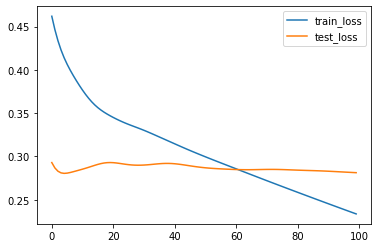

Done!


In [35]:
epochs = 100
train_losses = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append(train_loop(train_dataloader, m, loss_func, optimizer))
    test_losses.append(test_loop(test_dataloader, m, loss_func))
    clear_output(wait=True)
    plt.plot(train_losses, label="train_loss")
    plt.plot(test_losses, label="test_loss")
    plt.legend()
    plt.show()
print("Done!")